### TravelMode Tutorial

This notebook provides a simple example of how to use Dask and PyTorch to manipulate a simple consumer choice dataset. The toy dataset is [TravelMode](https://rdrr.io/cran/AER/man/TravelMode.html), a small consumer choice dataset recording individual's choice of travel from Sydney to Melbourne, from the R package AER. The model estimated is a multinomial logit model. 

In [34]:
import dask.dataframe as dd
import dask.array as da 
import pandas as pd 
import matplotlib.pyplot as plt

#### I. Manipulate Data in Dask and Store as HDF5 

In [35]:
df = dd.read_csv("example/TravelMode.csv",sep=",")
df.head()

,Unnamed: 0,individual,mode,choice,wait,vcost,travel,gcost,income,size
0,1,1,air,no,69,59,100,70,35,1
1,2,1,train,no,34,31,372,71,35,1
2,3,1,bus,no,35,25,417,70,35,1
3,4,1,car,yes,0,10,180,30,35,1
4,5,2,air,no,64,58,68,68,30,2


In [36]:
# clean up data 
df = df.mask(df=='yes',1)
df = df.mask(df=='no',0)
df = df.categorize(columns=['mode'])
df["choice"] = df["choice"].astype(int)
df["item_idx"] = df["mode"].cat.codes
df = df.drop(['Unnamed: 0','mode'],axis=1)
df.head()
df.dtypes

/Users/evanmunro/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


individual    int64
choice        int64
wait          int64
vcost         int64
travel        int64
gcost         int64
income        int64
size          int64
item_idx       int8
dtype: object

In [37]:
chosen = df[df['choice']==1].persist()
print("Number of choices: ", chosen.item_idx.nunique().compute()) 
print("Number of choice sessions: ",chosen.individual.nunique().compute())
print("Average Wait of Chosen: ", chosen.wait.mean().compute())
print("Average GCost of Chosen: ",chosen.gcost.mean().compute())
chosen.head()

Number of choices:  4
Number of choice sessions:  210
Average Wait of Chosen:  25.00952380952381
Average GCost of Chosen:  103.82380952380953


,individual,choice,wait,vcost,travel,gcost,income,size,item_idx
3,1,1,0,10,180,30,35,1,3
7,2,1,0,11,255,50,30,2,3
11,3,1,0,23,720,101,40,1,3
15,4,1,0,5,180,32,70,3,3
19,5,1,0,8,600,99,45,2,3


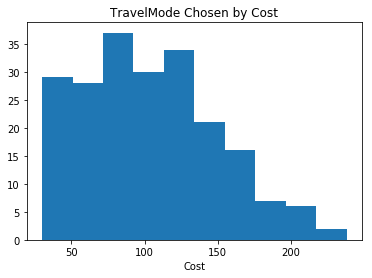

In [38]:
plt.figure() 
costSum = chosen.gcost.compute() 
costSum.hist()
plt.xlabel('Cost')
plt.title('TravelMode Chosen by Cost')
plt.grid()
plt.show()

In [39]:
df['log_gcost'] = da.log(df['gcost'])
df = df.set_index(df.individual,sorted=True)

/Users/evanmunro/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [40]:
df.to_hdf('TravelMode.h5','/data')
df['individual'].drop_duplicates().to_hdf('TravelMode.h5','/sessions')
df['individual'].drop_duplicates().to_hdf('TravelMode.h5','/users')
df['item_idx'].drop_duplicates().to_hdf('TravelMode.h5','/items')

['TravelMode.h5']

In [196]:
#make sure that HDF5 file saved correctly 
test = dd.read_hdf('TravelMode.h5','/items')
test.head()

/Users/evanmunro/anaconda3/lib/python3.6/site-packages/dask/dataframe/core.py:4495: UserWarning: Insufficient elements for `head`. 5 elements requested, only 4 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


individual
1    0
1    1
1    2
1    3
Name: item_idx, dtype: int8

#### II. Train and Estimate Multinomial Logit Model

In [1]:
from choiceModels import MultinomialLogit 
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F 
import torch.nn as nn 
import torch
from torch.autograd import Variable 

First define dataset class to load data for training models

In [3]:
#First Define Dataset Class
class TravelDataset(Dataset):
    def __init__(self, filename,choice_var,feature_vars):
        choiceData = pd.HDFStore(filename)
        print(choiceData.keys())
        #For too big memory for data, can query chunks of data at a time 
        query = "index>="+str(0)
        self.data = choiceData.select("data",query)
        self.sessions = choiceData["sessions"]
        self.length = len(choiceData["sessions"])
        print(self.length)
        self.choiceVar = choice_var
        self.features = feature_vars
      
    def __getitem__(self, idx):
        session = self.data[self.data.index==(idx+1)]
        session_x = session[self.features]
        label = session[session[self.choiceVar]==1].item_idx.item()
        return (torch.tensor(session_x.to_numpy()), torch.tensor(label))  

    def __len__(self):
        return self.length
    

Then, set up model 

In [28]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
datapath = "TravelMode.h5"
featureCols = ["wait","travel","gcost"]
choiceVar = "choice"

train_data = TravelDataset(datapath,choiceVar,featureCols)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3, shuffle=True, num_workers=0)

#define model (look at code in presentation)
model = MultinomialLogit(len(featureCols))
model.to(device)  

#optimize log-likelihood for multinomial logit 
criterion = nn.NLLLoss() 
#batch SGD with momentum
optimizer = torch.optim.SGD(model.parameters(),momentum=0.9,lr=0.000001)

['/data', '/items', '/sessions', '/users']
210


Then, train model with batch gradient descent and approximate results from R: 

In [29]:
torch.manual_seed(100) 
for epoch in range(1000): 
    corrects = 0 
    running_loss = 0 
    for data in train_loader: 
        inputs, labels = data 
        inputs, labels = Variable(inputs.float()), Variable(labels)   
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad() 
        outputs = model(inputs)
        _,preds = torch.max(outputs.data,1)
        loss = criterion(outputs,labels)
        corrects += torch.sum(labels.data == preds)
        running_loss += loss.data.item()   
        #step of SGD 
        loss.backward() 
        optimizer.step()
        #for name, param in model.named_parameters(): 
        #    print(name,param.data) 
    if epoch%100==0: 
        print(epoch," training Loss: ", running_loss/len(train_data))
        print("Training number correct: ", 100*corrects.item()/len(train_data))
        for name, param in model.named_parameters(): 
            if param.requires_grad: 
                print(name,param.data) 

0  training Loss:  7.193516769295647
Training number correct:  19.047619047619047
linear.weight tensor([[-0.5134,  0.0013,  0.2273]])
100  training Loss:  0.41985761324564613
Training number correct:  46.666666666666664
linear.weight tensor([[-0.0494, -0.0048,  0.0249]])
200  training Loss:  0.40327880354154677
Training number correct:  40.476190476190474
linear.weight tensor([[-0.0364, -0.0032,  0.0122]])
300  training Loss:  0.39709266963459194
Training number correct:  42.38095238095238
linear.weight tensor([[-0.0368, -0.0036,  0.0120]])
400  training Loss:  0.39568971225193567
Training number correct:  43.333333333333336
linear.weight tensor([[-0.0367, -0.0038,  0.0123]])
500  training Loss:  0.4046887684436071
Training number correct:  40.95238095238095
linear.weight tensor([[-0.0368, -0.0044,  0.0118]])
600  training Loss:  0.4247403058267775
Training number correct:  38.57142857142857
linear.weight tensor([[-0.0366, -0.0017,  0.0116]])
700  training Loss:  0.40055812228293647
Tr

Finally, train model with first order gradient descent to exactly match the results from R:  

In [32]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=210, shuffle=True, num_workers=0)
torch.manual_seed(100) 
for epoch in range(300): 
    corrects = 0 
    running_loss = 0 
    for data in train_loader: 
        inputs, labels = data 
        inputs, labels = Variable(inputs.float()), Variable(labels)   
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad() 
        outputs = model(inputs)
        _,preds = torch.max(outputs.data,1)
        loss = criterion(outputs,labels)
        corrects += torch.sum(labels.data == preds)
        running_loss += loss.data.item()   
        #step of SGD 
        loss.backward() 
        optimizer.step()
        #for name, param in model.named_parameters(): 
        #    print(name,param.data) 
    if epoch%100==0: 
        print(epoch," training Loss: ", loss.data.item())
        print("Training number correct: ", 100*corrects.item()/len(train_data))
        for name, param in model.named_parameters(): 
            if param.requires_grad: 
                print(name,param.data) 

0  training Loss:  1.1684355735778809
Training number correct:  45.23809523809524
linear.weight tensor([[-0.0363, -0.0036,  0.0118]])
100  training Loss:  1.168421983718872
Training number correct:  45.23809523809524
linear.weight tensor([[-0.0362, -0.0036,  0.0119]])
200  training Loss:  1.1684167385101318
Training number correct:  45.23809523809524
linear.weight tensor([[-0.0362, -0.0036,  0.0119]])


This is what Multinomial Logit Class in choiceModels looks like: 

```
class MultinomialLogit(torch.nn.Module):

    def __init__(self,m):
        super(MultinomialLogit2,self).__init__()
        self.linear = torch.nn.Linear(m,1,bias=False)
        self.lsmax = torch.nn.LogSoftmax(1)

    def forward(self,x):
        y_pred=self.linear(x)
        y_pred=self.lsmax(y_pred)
        return y_pred.squeeze()
    ```